In [4]:
import torch as t
import transformers
from einops import *
from typing import *
import matplotlib.pyplot as plt
device = "cuda:3"




In [10]:
model = None
model = transformers.AutoModelForCausalLM.from_pretrained("gpt2-xl")
model.to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2-xl")
print(model)
model.last_acts = []
for layer in model.transformer.h:
    layer.mlp.register_forward_hook(
        lambda module, input, output: model.last_acts.append(output)
    )

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
     

In [6]:
print(tokenizer.decode(model.generate(tokenizer("The Eiffel Tower is located in the city of",return_tensors="pt")["input_ids"].to(device))[0]))
print(tokenizer.decode(model.generate(tokenizer("The Colosseum is located in the city of",return_tensors="pt")["input_ids"].to(device))[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The Eiffel Tower is located in the city of Paris, France. The tower is the tallest
The Colosseum is located in the city of Rome, Italy. It is the largest Roman


[tensor([[[13.5262],
         [ 3.8200]]], device='cuda:3'), tensor([[[ 5.0347],
         [12.6485]]], device='cuda:3')]
out tokens [[6342], [10598]]
tensor([[-9.7061, -9.7419, -9.6973, -9.6970, -9.6586, -9.7063, -9.7081, -9.7093,
         -9.6939, -9.7055, -9.7067],
        [-9.7079, -9.7242, -9.7019, -9.6821, -9.6573, -9.6949, -9.7047, -9.7562,
         -9.7042, -9.7114, -9.7598],
        [-9.7005, -9.7315, -9.6913, -9.6717, -9.6624, -9.6870, -9.7002, -9.7852,
         -9.7025, -9.7109, -9.7902],
        [-9.7045, -9.7193, -9.6804, -9.6641, -9.6325, -9.6843, -9.7039, -9.8033,
         -9.6984, -9.7159, -9.8077],
        [-9.7038, -9.7254, -9.6610, -9.6723, -9.6595, -9.6815, -9.7143, -9.8139,
         -9.6995, -9.7180, -9.8215],
        [-9.7026, -9.7171, -9.6744, -9.6871, -9.6197, -9.6780, -9.7126, -9.8241,
         -9.6996, -9.7182, -9.8324],
        [-9.7023, -9.7062, -9.6729, -9.6516, -9.5889, -9.6774, -9.7260, -9.8310,
         -9.7001, -9.7177, -9.8369],
        [-9.7047, -9.702

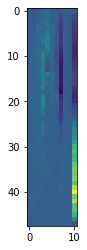

In [35]:
def get_switched_activations(model, main_text, alternatives):
    main_tokens = tokenizer(main_text)["input_ids"]
    alternatives_tokens = [
        (tokenizer(x[0])["input_ids"], tokenizer(x[1])["input_ids"])
        for x in alternatives
    ]
    assert all([len(x[1]) == 1 for x in alternatives_tokens])
    alternative_inputs = [t.tensor(x[0]+main_tokens) for x in alternatives_tokens]
    alternative_activations = []
    logits_in_question = []
    for ipt,a_t in zip(alternative_inputs,alternatives_tokens):
        with t.no_grad():
            logits = model(ipt.unsqueeze(0).to(device)).logits
        logits_in_question.append(logits[:,-1,[at[1] for at in alternatives_tokens]])
        alternative_activations.append(model.last_acts)
        model.last_acts=[]
    return alternative_activations, logits_in_question, alternative_inputs, [x[1] for x in alternatives_tokens]
    
def evaluate_switched_mlp_activations(model, main_text,alternatives,frac=0.1):
    acts, logits_in_question,inputs,out_tokens = get_switched_activations(model, main_text, alternatives)
    print("out tokens", out_tokens)
    n_layers, n_tokens = len(acts[0]), acts[0][0].shape[1]
    # batching this ugh
    diffs= []
    for layer_idx in range(n_layers):
        def hook(module,input,output_t):
            output=output_t[0]
            output = output+0
            for token_idx in range(n_tokens):
                output[token_idx,token_idx] =output[0,token_idx]*(1-frac)+frac*acts[1][layer_idx][0,token_idx]
            return (output,)+output_t[1:]
        try:
            hook_handle = model.transformer.h[layer_idx].register_forward_hook(hook)
            input_batch = repeat(inputs[0], "a -> z a",z=n_tokens)
            with t.no_grad():
                l_i_q = model(input_batch.to(device)).logits[:, -1, out_tokens]
            diff = l_i_q[:,1]-l_i_q[:,0]
        finally:
            hook_handle.remove()
        diffs.append(diff)
    diffs = t.stack(diffs).squeeze(-1).cpu()
    print(diffs)
    print("diffs shape", diffs.shape)
    return plt.imshow(diffs)
    return diffs
examples = [[" is located in the city of", [["The Eiffel Tower"," Paris"], ["The Colosseum", " Rome"]]],
[" is a major attraction of the city of", [["The Eiffel Tower"," Paris"], ["The Colosseum", " Rome"]]]]
a, l,i,it = get_switched_activations(model, *examples[0])
print(l)
evaluate_switched_mlp_activations(model,*examples[0])